## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.style.use('dark_background' )
from cycler import cycler       # cycler(linestyle=['-','--',':','-.') * cycler(color=colors) cycler(lw=[1,5])
plt.rc('axes', prop_cycle=cycler(color=list('rbygmcw')+['orangered', 'gray', 'gold','coral']))

import os
import sys

from scipy import stats
from scipy.signal import savgol_filter
from scipy.ndimage import generic_filter
from scipy.signal import freqz
from scipy.signal import butter, lfilter

from google.colab import drive
drive.mount('/gdrive')

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

Mounted at /gdrive


## Data Loading and Preprocessing

In [2]:
import glob

# Replace this with the directory containing your training files
data_directory = "/gdrive/MyDrive/ai-labs-2022/caretech/data/signals_for_transformer"

# Get a list of all the files ending with '_X.npy'
x_files = glob.glob(os.path.join(data_directory, "*_X.npy"))

X_train = []
y_train = []

for x_file in x_files:
    # Load the X data
    X = np.load(x_file)
    X = np.reshape(X, (12000, 1))  # Reshape if necessary
    X_train.append(X)

    # Load the corresponding Y data
    y_file = x_file[:-6] + "_Y.npy"
    Y = np.load(y_file)
    Y = np.reshape(Y, (12000, 2))  # Reshape if necessary
    y_train.append(Y)

# Convert the lists to numpy arrays
X_data = np.array(X_train)
y_data = np.array(y_train)

print("X_data shape:", X_data.shape)
print("y_data shape:", y_data.shape)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_data shape: (263, 12000, 1)
y_data shape: (263, 12000, 2)
X_train shape: (210, 12000, 1)
X_test shape: (53, 12000, 1)
y_train shape: (210, 12000, 2)
y_test shape: (53, 12000, 2)


## Model Architecture

In [3]:
from sklearn.preprocessing import MinMaxScaler

# Convert the lists to numpy arrays
X_data = np.array(X_train)[:, :9500, :]
y_data = np.array(y_train)[:, :9500, :]

# Create a scaler object
scaler = MinMaxScaler()

# Reshape the signal part of the data to 2D, apply the scaler, and then reshape it back to 3D
X_data[:, :, 0] = scaler.fit_transform(X_data[:, :, 0].reshape(-1, 1)).reshape(X_data.shape[0], X_data.shape[1])
y_data[:, :, 0] = scaler.fit_transform(y_data[:, :, 0].reshape(-1, 1)).reshape(y_data.shape[0], y_data.shape[1])

print("X_data shape:", X_data.shape)
print("y_data shape:", y_data.shape)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_data shape: (210, 9500, 1)
y_data shape: (210, 9500, 2)
X_train shape: (168, 9500, 1)
X_test shape: (42, 9500, 1)
y_train shape: (168, 9500, 2)
y_test shape: (42, 9500, 2)


## Custom Loss Function

In [4]:
def custom_loss(y_true, y_pred, alpha=0.1, beta=0.1, WS=50):
    y_true_signal = y_true[:, :, 0]
    y_pred_signal = y_pred[:, :, 0]

    # Calculate the number of chunks for smoothing
    num_chunks = tf.shape(y_pred_signal)[1] // WS

    # Reshape the predicted signal into chunks
    pred_chunks = tf.reshape(y_pred_signal[:, :num_chunks * WS], (-1, WS))

    # Smooth each chunk by taking the mean
    smoothed_pred_chunks = tf.reduce_mean(pred_chunks, axis=1)

    # Repeat and reshape the smoothed chunks to match the original signal length
    smoothed_pred_signal = tf.reshape(tf.repeat(smoothed_pred_chunks, WS), tf.shape(y_pred_signal))

    # Calculate the mean squared error
    mse = tf.keras.losses.MeanSquaredError()(y_true_signal, smoothed_pred_signal)

    y_true_segmentation = tf.one_hot(tf.squeeze(tf.cast(y_true[:, :, 1], dtype=tf.int32)), depth=5)
    y_pred_segmentation = y_pred[:, :, 1:]
    segmentation_loss = tf.keras.losses.categorical_crossentropy(y_true_segmentation, y_pred_segmentation, from_logits=False)

    beta = tf.cast(beta, dtype=mse.dtype)

    return mse + alpha * segmentation_loss + beta


## Model Architecture

In [5]:
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import UpSampling1D
from tensorflow.keras.layers import Lambda
from tensorflow.keras.regularizers import l2



def transformer_encoder(inputs, num_heads=8, dff=2048, rate=0.1):
    x = inputs
    for _ in range(3):
        attn_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=x.shape[-1])(x, x)
        attn_output = tf.keras.layers.Dropout(rate)(attn_output)
        out1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + attn_output)

        ffn_output = tf.keras.layers.Dense(dff, activation="relu")(out1)
        ffn_output = tf.keras.layers.Dense(x.shape[-1])(ffn_output)
        ffn_output = tf.keras.layers.Dropout(rate)(ffn_output)

        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

    return x


def create_model():
    input_layer = Input(shape=(9500, 1))
    
    x = Conv1D(16, 5, activation='relu', padding='same')(input_layer)
    x = MaxPooling1D(2, padding='same')(x)
    
    x = transformer_encoder(x)
    
    x = UpSampling1D(2)(x)
    
    # Pad sequences back to original length
    x = Lambda(lambda x: tf.pad(x, paddings=[[0, 0], [0, 9500 - tf.shape(x)[1]], [0, 0]]))(x)
    
    output_signal = Dense(1, activation='relu', kernel_regularizer=l2(1e-4))(x)  # Added 'relu' activation
    output_signal = Lambda(lambda x: tf.squeeze(x, axis=-1))(output_signal)
    output_segmentation = Dense(5, activation='softmax', kernel_regularizer=l2(1e-4))(x)
    
    output = tf.keras.layers.Concatenate(axis=-1)([tf.expand_dims(output_signal, axis=-1), output_segmentation])
    
    model = Model(inputs=input_layer, outputs=output)
    
    return model

# Create and compile the model
model = create_model()

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss=lambda y_true, y_pred: custom_loss(y_true, y_pred))

# Fit the model for the first 100 epochs with learning rate 0.001
history = model.fit(X_train, y_train, batch_size=4, epochs=300, validation_split=0.1)

Epoch 1/300
38/38 [==============================] - 125s 277ms/step - loss: 0.3203 - val_loss: 0.2411
Epoch 2/300
38/38 [==============================] - 9s 230ms/step - loss: 0.2287 - val_loss: 0.2247
Epoch 3/300
38/38 [==============================] - 9s 230ms/step - loss: 0.2218 - val_loss: 0.2213
Epoch 4/300
38/38 [==============================] - 9s 229ms/step - loss: 0.2183 - val_loss: 0.2203
Epoch 5/300
38/38 [==============================] - 9s 230ms/step - loss: 0.2152 - val_loss: 0.2166
Epoch 6/300
38/38 [==============================] - 9s 231ms/step - loss: 0.2120 - val_loss: 0.2154
Epoch 7/300
38/38 [==============================] - 9s 229ms/step - loss: 0.2052 - val_loss: 0.1992
Epoch 8/300
38/38 [==============================] - 9s 230ms/step - loss: 0.1946 - val_loss: 0.1979
Epoch 9/300
38/38 [==============================] - 9s 230ms/step - loss: 0.1905 - val_loss: 0.1908
Epoch 10/300
38/38 [==============================] - 9s 230ms/step - loss: 0.1887 - val_

## Visualization of Results

1/1 [==============================] - 2s 2s/step


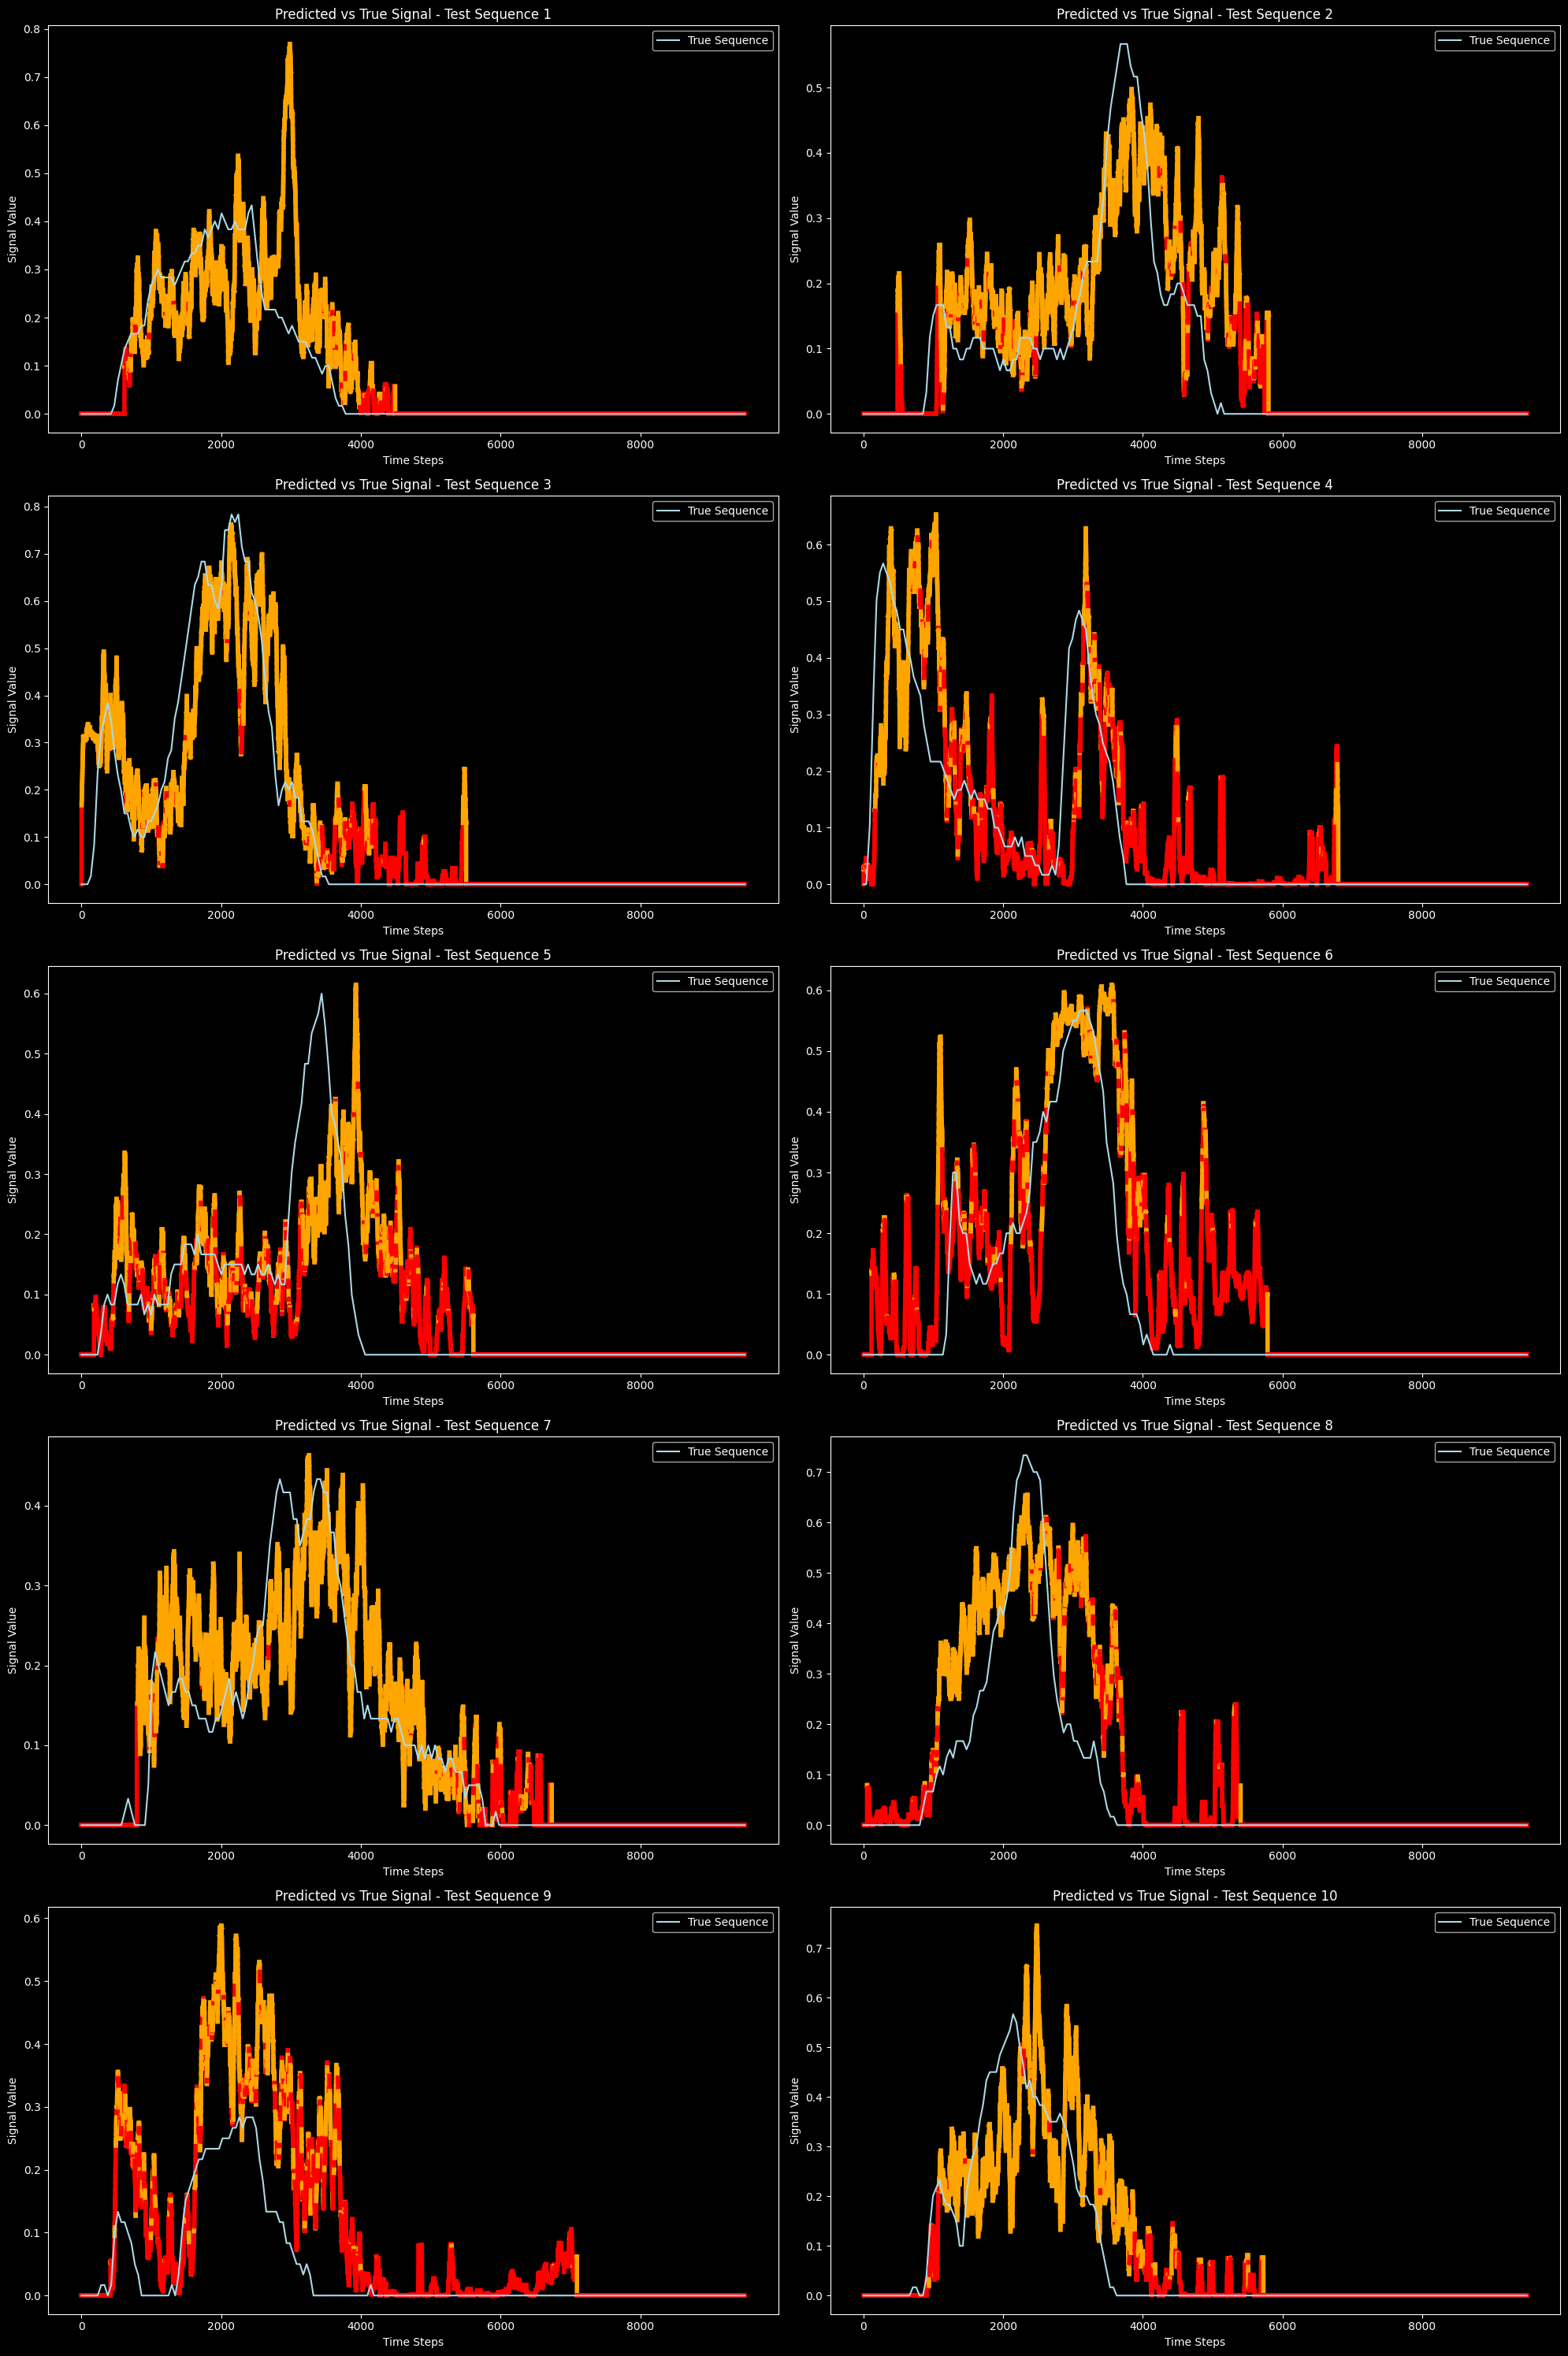

In [6]:
import numpy as np
import matplotlib.pyplot as plt


WS = 50  # Define the window size for smoothing

# Make predictions using the model
predicted_sequences = model.predict(X_test[:10])

# Replace all negative values with 0
predicted_sequences = np.maximum(predicted_sequences, 0)


# Define segment colors
colors = {
    0: 'red',   # no_flow
    1: 'orange',   # flow
    2: 'yellow',    # max
}

# Create a single plot with a grid of 2 columns
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 30))

for i in range(10):
    ax = axes[i // 2, i % 2]

    # Get the predicted segmentation mask for the sequence
    predicted_segmentation_mask = np.argmax(predicted_sequences[i, :, 1:], axis=1)

    index_1 = np.where(predicted_segmentation_mask == 1)

    if index_1[0].size > 0:
        n1 = index_1[0][0]
        n2 = index_1[0][-1] + 1

        # Smooth the predicted signal
        predicted_sequences[i, :, 0] = np.convolve(predicted_sequences[i, :, 0], np.ones(WS) / WS, mode='same')

        # Apply cutoff to the smoothed signal
        predicted_sequences[i, :, 0][:n1] = 0
        predicted_sequences[i, :, 0][n2:] = 0

    # Plot the predicted sequence with different colors based on the predicted segment class
    for j in range(len(predicted_sequences[i, :, 0]) - 1):
        segment_class = predicted_segmentation_mask[j]
        ax.plot([j, j+1], [predicted_sequences[i, :, 0][j], predicted_sequences[i, :, 0][j+1]],
                 color=colors[segment_class], linewidth=4)

    ax.plot(y_test[i, :, 0], label='True Sequence', c='lightblue')

    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Signal Value')
    ax.legend()
    ax.set_title(f'Predicted vs True Signal - Test Sequence {i + 1}')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 185ms/step


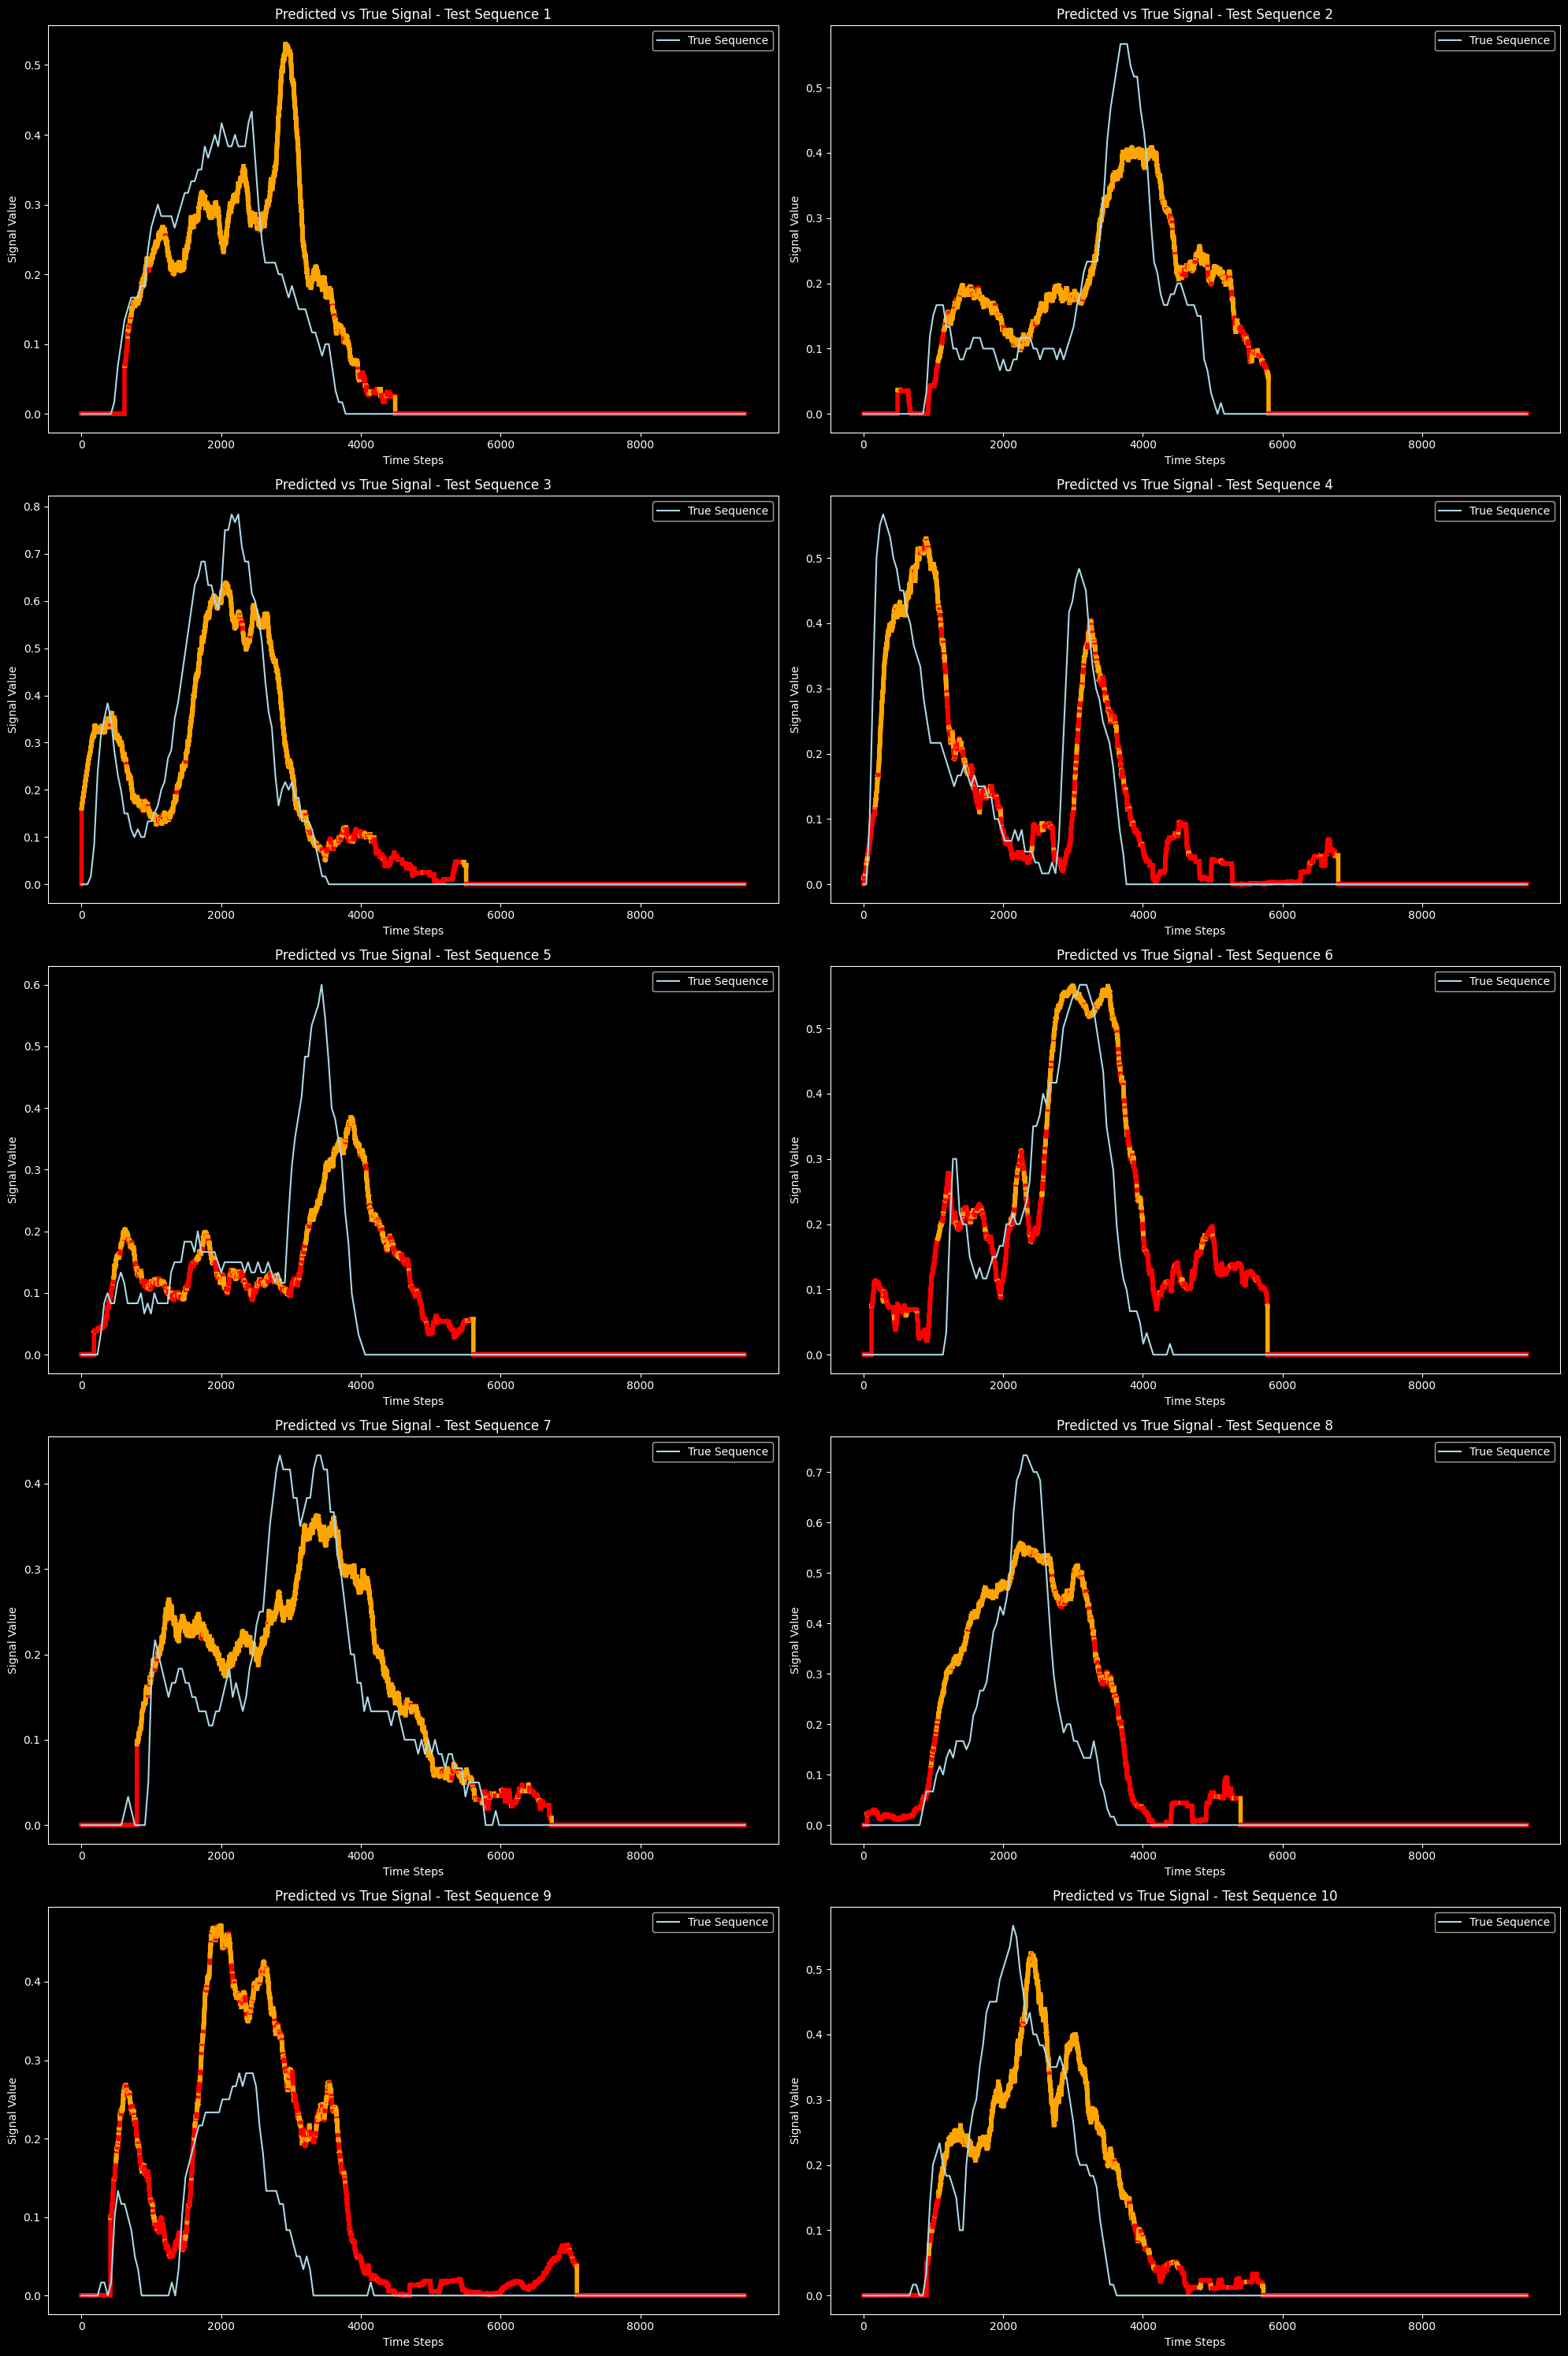

In [7]:
import numpy as np
import matplotlib.pyplot as plt


WS = 300  # Define the window size for smoothing

# Make predictions using the model
predicted_sequences = model.predict(X_test[:10])

# Replace all negative values with 0
predicted_sequences = np.maximum(predicted_sequences, 0)


# Define segment colors
colors = {
    0: 'red',   # no_flow
    1: 'orange',   # flow
    2: 'yellow',    # max
}

# Create a single plot with a grid of 2 columns
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 30))

for i in range(10):
    ax = axes[i // 2, i % 2]

    # Get the predicted segmentation mask for the sequence
    predicted_segmentation_mask = np.argmax(predicted_sequences[i, :, 1:], axis=1)

    index_1 = np.where(predicted_segmentation_mask == 1)

    if index_1[0].size > 0:
        n1 = index_1[0][0]
        n2 = index_1[0][-1] + 1

        # Smooth the predicted signal
        predicted_sequences[i, :, 0] = np.convolve(predicted_sequences[i, :, 0], np.ones(WS) / WS, mode='same')

        # Apply cutoff to the smoothed signal
        predicted_sequences[i, :, 0][:n1] = 0
        predicted_sequences[i, :, 0][n2:] = 0

    # Plot the predicted sequence with different colors based on the predicted segment class
    for j in range(len(predicted_sequences[i, :, 0]) - 1):
        segment_class = predicted_segmentation_mask[j]
        ax.plot([j, j+1], [predicted_sequences[i, :, 0][j], predicted_sequences[i, :, 0][j+1]],
                 color=colors[segment_class], linewidth=4)

    ax.plot(y_test[i, :, 0], label='True Sequence', c='lightblue')

    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Signal Value')
    ax.legend()
    ax.set_title(f'Predicted vs True Signal - Test Sequence {i + 1}')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()